In [1]:
from functools import cached_property

import numpy as np
import plotly.graph_objects as go
from scipy import optimize
from sympy import Ellipse, Function
from sympy import Point as Point2D
from sympy import acos, atan, cos, pi, sin, sqrt, symbols, tan
from sympy.abc import t
from sympy.physics.units import gravitational_constant as G
from sympy.physics.vector import Point, ReferenceFrame
from sympy.utilities.lambdify import implemented_function, lambdify

In [2]:
def eccentric_anomaly_solution(eccentric_anomaly, eccentricity, mean_anomaly):
    return eccentric_anomaly - eccentricity * np.sin(eccentric_anomaly) - mean_anomaly


def fprime_eccentric_anomaly(eccentric_anomaly, eccentricity, _):
    return 1 - eccentricity * np.cos(eccentric_anomaly)


def compute_eccentric_anomaly(mean_anomaly, eccentricity):
    return optimize.newton(
        eccentric_anomaly_solution,
        mean_anomaly,
        fprime_eccentric_anomaly,
        (eccentricity, mean_anomaly),
        maxiter=1000,
        tol=1e-10,
    )

In [3]:
def OrbitalFrame(
    name, equatorial_frame, longitude_ascending_node, inclination, argument_of_periapsis
):
    orbital_frame = ReferenceFrame(name)
    orbital_frame.orient_body_fixed(
        equatorial_frame,
        [longitude_ascending_node, inclination, argument_of_periapsis],
        "313",
    )
    return orbital_frame


def OrbitalPeriod(
    primary_mass, secondary_mass, semimajor_axis, gravitational_constant=G
):
    mean_angular_motion = sqrt(
        gravitational_constant * (primary_mass + secondary_mass) / (semimajor_axis ** 3)
    )
    return 2 * pi / mean_angular_motion


def EllipseInFrame(frame, semimajor_axis, eccentricity, parameter=t):
    orbit = Ellipse(
        Point2D(-semimajor_axis * eccentricity, 0),
        hradius=semimajor_axis,
        eccentricity=eccentricity,
    )
    x, y = orbit.arbitrary_point(parameter=parameter)
    return x * frame.x + y * frame.y


def EccentricAnomalyFromTrueAnomaly(true_anomaly, eccentricity):
    return acos(
        (eccentricity + cos(true_anomaly)) / (1 + eccentricity * cos(true_anomaly))
    )


def MeanAnomalyFromEccentricAnomaly(eccentric_anomaly, eccentricity):
    return eccentric_anomaly - eccentricity * sin(eccentric_anomaly)


def MeanAnomalyAtT(mean_anomaly_at_epoch, period, t):
    return mean_anomaly_at_epoch + (2 * pi / period) * t


def EccentricAnomalyFromMeanAnomaly(mean_anomaly, eccentricity):
    compute_eccentric_anomaly_function = implemented_function(
        Function("Ecc"), compute_eccentric_anomaly
    )
    return compute_eccentric_anomaly_function(mean_anomaly, eccentricity)


def TrueAnomalyFromEccentricAnomaly(eccentric_anomaly, eccentricity):
    return 2 * atan(
        sqrt((1 + eccentricity) / (1 - eccentricity)) * tan(eccentric_anomaly / 2)
    )


def TrueAnomalyAtT(true_anomaly_at_epoch, eccentricity, period, t):
    eccentric_anomaly_at_epoch = EccentricAnomalyFromTrueAnomaly(
        true_anomaly_at_epoch, eccentricity
    )
    mean_anomaly_at_epoch = MeanAnomalyFromEccentricAnomaly(
        eccentric_anomaly_at_epoch, eccentricity
    )

    mean_anomaly = MeanAnomalyAtT(mean_anomaly_at_epoch, period, t)

    eccentric_anomaly = EccentricAnomalyFromMeanAnomaly(mean_anomaly, eccentricity)
    return TrueAnomalyFromEccentricAnomaly(eccentric_anomaly, eccentricity)


def OrbitalRadius(semimajor_axis, eccentricity, true_anomaly):
    return (semimajor_axis * (1 - eccentricity ** 2)) / (
        1 + eccentricity * cos(true_anomaly)
    )


def OrbitalVector(orbital_frame, semimajor_axis, eccentricity, true_anomaly):
    radius = OrbitalRadius(semimajor_axis, eccentricity, true_anomaly)
    return orbital_frame.x * radius * cos(
        true_anomaly
    ) + orbital_frame.y * radius * sin(true_anomaly)

In [4]:
# TODO: Lambdify could be optimized with some `subs` first for proper parameters

class Body:
    def __init__(self, name):
        self.name = name
        self.mass = symbols(f"m_{name}")
        self.equatorial_frame = ReferenceFrame(f"E_{name}")


class Orbit:
    def __init__(self, primary_body, secondary_body):
        self.primary_body = primary_body
        self.secondary_body = secondary_body

        self.eccentricity = symbols(f"e_{secondary_body.name}")
        self.semimajor_axis = symbols(f"a_{secondary_body.name}")
        self.true_anomaly_at_epoch = symbols(f"ν_{secondary_body.name}")
        self.inclination = symbols(f"i_{secondary_body.name}")
        self.longitude_ascending_node = symbols(f"Ω_{secondary_body.name}")
        self.argument_of_periapsis = symbols(f"ω_{secondary_body.name}")

    @cached_property
    def orbital_frame(self):
        return OrbitalFrame(
            f"O_{self.secondary_body.name}",
            self.primary_body.equatorial_frame,
            self.longitude_ascending_node,
            self.inclination,
            self.argument_of_periapsis,
        )

    @cached_property
    def period(self):
        return OrbitalPeriod(
            self.primary_body.mass, self.secondary_body.mass, self.semimajor_axis
        )

    @cached_property
    def orbital_ellipse(self):
        return EllipseInFrame(
            self.orbital_frame, self.semimajor_axis, self.eccentricity, t
        ).express(self.primary_body.equatorial_frame)
    
    @cached_property
    def orbital_ellipse_lambda(self):
        return lambdify(
            (
                self.semimajor_axis,
                self.eccentricity,
                self.longitude_ascending_node,
                self.inclination,
                self.argument_of_periapsis,
                t,
            ),
            # TODO: reference frame should be configurable, not always primary_body.equatorial_frame
            self.orbital_ellipse.to_matrix(self.primary_body.equatorial_frame)
            .transpose()
            .tolist()[0],
        )
    

class OrbitProjection:
    def __init__(self, orbit, t):
        self.orbit = orbit
        self.t = t
        
    @cached_property
    def true_anomaly(self):
        return TrueAnomalyAtT(
            self.orbit.true_anomaly_at_epoch,
            self.orbit.eccentricity,
            self.orbit.period,
            self.t
        )
    
    @cached_property
    def orbital_vector(self):
        return OrbitalVector(self.orbit.orbital_frame, self.orbit.semimajor_axis, self.orbit.eccentricity, self.true_anomaly)
    
    # TODO: OrbitProjection shouldn't be responsible for Point
    @cached_property
    def primary_body_as_point(self):
        return Point(self.orbit.primary_body.name)
    
    @cached_property
    def primary_body_position_lambda(self):
        return self._make_primary_body_position_lambda(self.primary_body_as_point)
    
    @cached_property
    def secondary_body_as_point(self):
        return self.primary_body_as_point.locatenew(
            self.orbit.secondary_body.name,
            self.orbital_vector
        )
    
    @cached_property
    def secondary_body_position_lambda(self):
        return self._make_primary_body_position_lambda(self.secondary_body_as_point)
    
    def _make_primary_body_position_lambda(self, body):
        return lambdify(
            (
                self.orbit.semimajor_axis,
                self.orbit.eccentricity,
                self.orbit.true_anomaly_at_epoch,
                self.orbit.longitude_ascending_node,
                self.orbit.inclination,
                self.orbit.argument_of_periapsis,
                self.orbit.primary_body.mass,
                self.orbit.secondary_body.mass,
                self.t,
                G,
            ),
            body.pos_from(self.primary_body_as_point)
            # TODO: reference frame should be configurable, not always primary_body.equatorial_frame
            .to_matrix(self.orbit.primary_body.equatorial_frame)
            .transpose()
            .tolist()[0],
        )

In [21]:
class QuantifiedBody:
    def __init__(self, name, mass):
        self.name = name
        self.mass = mass
        
    @cached_property
    def backend(self):
        return Body(self.name)

class QuantifiedOrbit:
    # TODO: Find a better place to define G
    G = 6.67408e-11
    
    def __init__(self, primary_body, secondary_body, semimajor_axis, eccentricity, true_anomaly_at_epoch, longitude_ascending_node, inclination, argument_of_periapsis):
        self.primary_body = primary_body
        self.secondary_body = secondary_body
        self.semimajor_axis = semimajor_axis
        self.eccentricity = eccentricity
        self.true_anomaly_at_epoch = true_anomaly_at_epoch
        self.longitude_ascending_node = longitude_ascending_node
        self.inclination = inclination
        self.argument_of_periapsis = argument_of_periapsis
        
    @cached_property
    def backend(self):
        return Orbit(self.primary_body.backend, self.secondary_body.backend)
    
    @cached_property
    def projection_backend(self):
        return OrbitProjection(self.backend, t)
        
    def ellipse(self, t_space):
        return [
            self.backend.orbital_ellipse_lambda(
                self.semimajor_axis,
                self.eccentricity,
                self.longitude_ascending_node,
                self.inclination,
                self.argument_of_periapsis,
                t,
            ) for t in t_space
        ]
    
    def primary_body_position(self, t):
        return self.projection_backend.primary_body_position_lambda(
            self.semimajor_axis,
            self.eccentricity,
            self.true_anomaly_at_epoch,
            self.longitude_ascending_node,
            self.inclination,
            self.argument_of_periapsis,
            self.primary_body.mass,
            self.secondary_body.mass,
            t,
            QuantifiedOrbit.G
        )
        
    def secondary_body_position(self, t):
        return self.projection_backend.secondary_body_position_lambda(
            self.semimajor_axis,
            self.eccentricity,
            self.true_anomaly_at_epoch,
            self.longitude_ascending_node,
            self.inclination,
            self.argument_of_periapsis,
            self.primary_body.mass,
            self.secondary_body.mass,
            t,
            QuantifiedOrbit.G
        )

In [22]:
# TODO: These values should be provided as part of a struct
sun = QuantifiedBody("Sun", 100)
earth = QuantifiedBody("Earth", 5)

sun_earth_orbit = QuantifiedOrbit(
    sun,
    earth,
    semimajor_axis=10,
    eccentricity=0.7,
    true_anomaly_at_epoch= 2,
    longitude_ascending_node=0.7,
    inclination=1,
    argument_of_periapsis=1.5,
)

t_val = 5

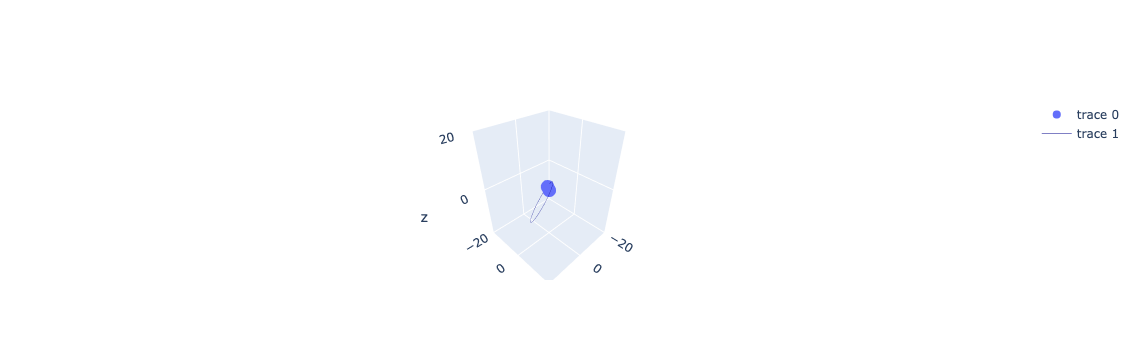

In [23]:
def trace_bodies(orbit, t):
    primary = orbit.primary_body_position(t)
    secondary = orbit.secondary_body_position(t)
    x, y, z = zip(primary, secondary)
    return go.Scatter3d(x=x, y=y, z=z, mode="markers")

def trace_orbit_ellipse(orbit):
    x_ellipse, y_ellipse, z_ellipse = np.transpose(
        orbit.ellipse(np.linspace(0, 2 * np.pi, 500))
    )
    return go.Scatter3d(
        x=x_ellipse,
        y=y_ellipse,
        z=z_ellipse,
        mode="lines",
        line=dict(color="darkblue", width=0.5),
    )

def plot_orbit(orbit, t):
    ellipse = trace_orbit_ellipse(orbit)
    bodies = trace_bodies(orbit, t)
    
    fig = go.Figure(data=[bodies, ellipse])
    fig.update_layout(
        scene=dict(
            xaxis=dict(nticks=4, range=[-2 * orbit.semimajor_axis, 2 * orbit.semimajor_axis],),
            yaxis=dict(nticks=4, range=[-2 * orbit.semimajor_axis, 2 * orbit.semimajor_axis],),
            zaxis=dict(nticks=4, range=[-2 * orbit.semimajor_axis, 2 * orbit.semimajor_axis],),
        )
    )
    return fig

fig = plot_orbit(sun_earth_orbit, t_val)
fig.show()